In [7]:
import re
import pymorphy2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pymystem3
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from stop_words import get_stop_words
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, chi2, SelectFromModel

In [8]:
morph = pymorphy2.MorphAnalyzer()

In [94]:
def string_to_trigramm(string):
    for item in string.split():
        for i in range(len(item)-3):
            yield item[i:i+4]

In [149]:
def get_data(file, answer=True):
    X = []
    Y = []
    cache = {}
    
    pattern = re.compile('([^\s\w]|_)+')

    with open(file) as f:
        content = f.readlines()[1:]

    for line in content:
        line_data = line.split(',')
        temp = line_data[1].lower()
        temp1 = temp
        
        temp = re.sub(r'[^а-я ]+', '', temp)
        temp = ' '.join([x for x in temp.split(' ')[1:-1] if len(x) > 2 and len(x) < 15])
        temp = ' '.join([morph.parse(x)[0].normal_form for x in temp.split(' ') if x])
        for x in get_stop_words('ru'):
            temp = re.sub(r"\b%s\b" % x , '', temp)
        temp += ' '.join([x for x in string_to_trigramm(temp)])

        X.append(temp1 + temp)
        if answer:
            Y.append(int(line_data[2][:-1]))
    return X, Y

In [150]:
def write_data(f_name, result):
    with open(f_name,'w') as file:
        file.write('id,prob\n')
    id = 0

    for i in range(len(result)):
        line = '{0},{1}\n'.format(id,result[i])
        id+=1
        file.write(line)

In [151]:
X, Y = get_data('data3/train.csv')

In [207]:
X[2]

'ся оправдать иру? или… позвонил ей на работу сказал поедет к нотариусу надо довнести картошку он почистил. ира повозмущалась потом сдалась. все равно тебя вылечу только и произнесла негромко. он повесил трубку быстро собрался. по дороге перебирая в кармане купюры вдруг вспомнил — их с пумкой фотографировал егор как раз весной в начале мая. было холодно. у него должны сохраниться фотографии он воправдать ир  позвонить работа  поехать нотариус  довнести картошка почистить ир повозмущаться  сдаться  равно  вылечить  произнести негромко повесить трубка быстро собраться дорога перебирать карман купюра  вспомнить пумка фотографировать егор   весной начало май  холодный  должный сохраниться фотографияопра прав равд авда вдат дать позв озво звон вони онит нить рабо абот бота поех оеха ехат хать нота отар тари ариу риус довн овне внес нест ести карт арто ртош тошк ошка почи очис чист исти стит тить пово овоз возм озму змущ муща ущат щать атьс ться сдат дать атьс ться равн авно выле ылеч лечи е

In [199]:
tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.7)
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [200]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf, Y, train_size=0.7)
X_train.shape

(9760, 64486)

In [201]:
sel = SelectKBest(chi2, k=5000)
sel.fit(X_train, Y_train)
X_train = sel.transform(X_train).toarray()
X_test = sel.transform(X_test).toarray()
X_train.shape

(9760, 5000)

In [202]:
len(sel.scores_)
10scores = sel.scores_
scores.sort()

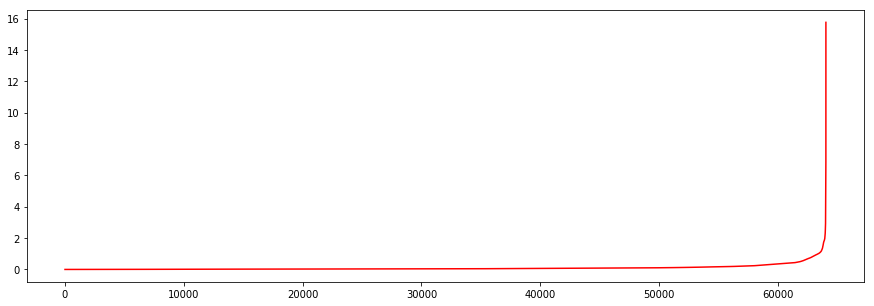

In [203]:
plt.figure(figsize=(15,5))
plt.plot([x for x in range(len(sel.scores_))], sel.scores_, c='red')
plt.show()

In [206]:
clf_bnb = BernoulliNB(alpha=0.0001)
clf_bnb.fit(X_train, Y_train)
Y_pred = clf_bnb.predict(X_test)
Y_pred_proba = clf_bnb.predict_proba(X_test)
Y_pred_prob = clf_bnb.predict_proba(X_train)
print('roc_auc', roc_auc_score(y_true=Y_test, y_score=Y_pred_proba[:,1]))
print('roc_auc', roc_auc_score(y_true=Y_train, y_score=Y_pred_prob[:,1]))
print(classification_report(y_true=Y_test, y_pred=Y_pred))

roc_auc 0.434420069475
roc_auc 0.964928716167
             precision    recall  f1-score   support

          0       0.90      0.81      0.85      3794
          1       0.06      0.12      0.08       390

avg / total       0.82      0.74      0.78      4184



In [193]:
clf_mnb = MultinomialNB(alpha=1)
clf_mnb.fit(X_train, Y_train)
Y_pred = clf_mnb.predict(X_test)
Y_pred_proba = clf_mnb.predict_proba(X_test)
Y_pred_prob = clf_bnb.predict_proba(X_train)
print('roc_auc', roc_auc_score(y_true=Y_test, y_score=Y_pred_proba[:,1]))
print('roc_auc', roc_auc_score(y_true=Y_train, y_score=Y_pred_prob[:,1]))
print(classification_report(y_true=Y_test, y_pred=Y_pred))

roc_auc 0.475252471397
roc_auc 0.958485046357
             precision    recall  f1-score   support

          0       0.90      1.00      0.95      3760
          1       0.00      0.00      0.00       424

avg / total       0.81      0.90      0.85      4184



/home/nikita/work/ml/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [197]:
iverted_vocab = {_id:w for (w,_id) in tfidf_vectorizer.vocabulary_.items()}
for _id in clf_bnb.coef_.argsort()[0][-150:]:
    print(iverted_vocab[_id], clf_bnb.coef_[0][_id])

варианта -3.57277769662
богиня -3.57277769662
бумажка -3.57277769662
бвор -3.57277769662
адекватный -3.57277769662
влия -3.57277769662
бвен -3.57277769662
база -3.57277769662
абсурд -3.57277769662
бухгалтерии -3.57277769662
блестеть -3.57277769662
азён -3.57277769662
вожд -3.57277769662
бинты -3.53503736864
возьмет -3.53503736864
вассал -3.53503736864
бинн -3.53503736864
вона -3.53503736864
вернется -3.53503736864
анив -3.53503736864
апри -3.53503736864
ачас -3.53503736864
взяло -3.53503736864
взрезать -3.53503736864
абсу -3.53503736864
браться -3.53503736864
благополучно -3.53503736864
вира -3.49866972447
бродил -3.49866972447
агия -3.49866972447
варька -3.49866972447
вздохи -3.49866972447
взмыла -3.46357840466
анальгин -3.46357840466
бархатный -3.46357840466
ажем -3.46357840466
бумажные -3.46357840466
вовка -3.46357840466
влиятельный -3.46357840466
60 -3.46357840466
васька -3.46357840466
бешеной -3.46357840466
атра -3.46357840466
бесполезный -3.46357840466
банку -3.46357840466
видное

In [198]:
iverted_vocab = {_id:w for (w,_id) in tfidf_vectorizer.vocabulary_.items()}
for _id in clf_mnb.coef_.argsort()[0][-150:]:
    print(iverted_vocab[_id], clf_mnb.coef_[0][_id])

бедняжка -7.99514040352
водка -7.99495245644
абго -7.99402267007
вовка -7.99109595401
большой -7.99067482773
васька -7.9887626459
виновник -7.9883777705
ас -7.98752006675
беременности -7.98752006675
ател -7.98691061432
битву -7.98641209628
вешал -7.98174593528
великое -7.9798818648
беременный -7.97453997456
брот -7.9739442211
анастасий -7.97312946655
варька -7.97099704393
анис -7.9651802522
актр -7.96515242536
text -7.95933271608
волх -7.95539296972
взой -7.95444032324
бвен -7.95187632965
астм -7.95002345557
вассал -7.94776553345
васс -7.94518297901
амоп -7.93597259846
вишн -7.93474847348
вкусная -7.93388854655
бдел -7.92938332542
анфи -7.92882496973
алев -7.92731097393
вздр -7.92603727778
веселиться -7.92038743085
атуш -7.91630989866
агонии -7.91240051128
булыжник -7.91133289701
вкусно -7.90588848578
визн -7.90558765434
алевтина -7.89884007968
брезгливый -7.89266117703
билось -7.88932348437
вечно -7.88901355514
алез -7.88682018991
арич -7.88519141941
ампула -7.88397355284
90 -7.882362